In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/LJMU_Data_XAI/data/aws-jupyter-notebooks/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading config from: config.yaml
Successfully loaded drift data from drift_reports/test_data_drift_report.pkl
DRIFT ANALYSIS SUMMARY
Analysis Timestamp: 2025-10-11T15:31:22.180893
Test Data Size: 55
Total Chunks Analyzed: 50

DATA DRIFT RESULTS:
              Model Chunk_ID  Data_Drift_Score  KS_Score  Cosine_Distance  Has_Drift
logistic_regression        3          0.104217  0.115461         0.092973       True
logistic_regression       10          0.096196  0.102485         0.089907       True
logistic_regression        1          0.090906  0.099331         0.082482       True
logistic_regression        6          0.092649  0.102007         0.083291       True
logistic_regression        7          0.091913  0.104370         0.079456       True
logistic_regression        5          0.090440  0.104094         0.076786       True
logistic_regression        4          0.099472  0.112889         0.086055       True
logistic_regression        2          0.111251  0.122169         0.100333 

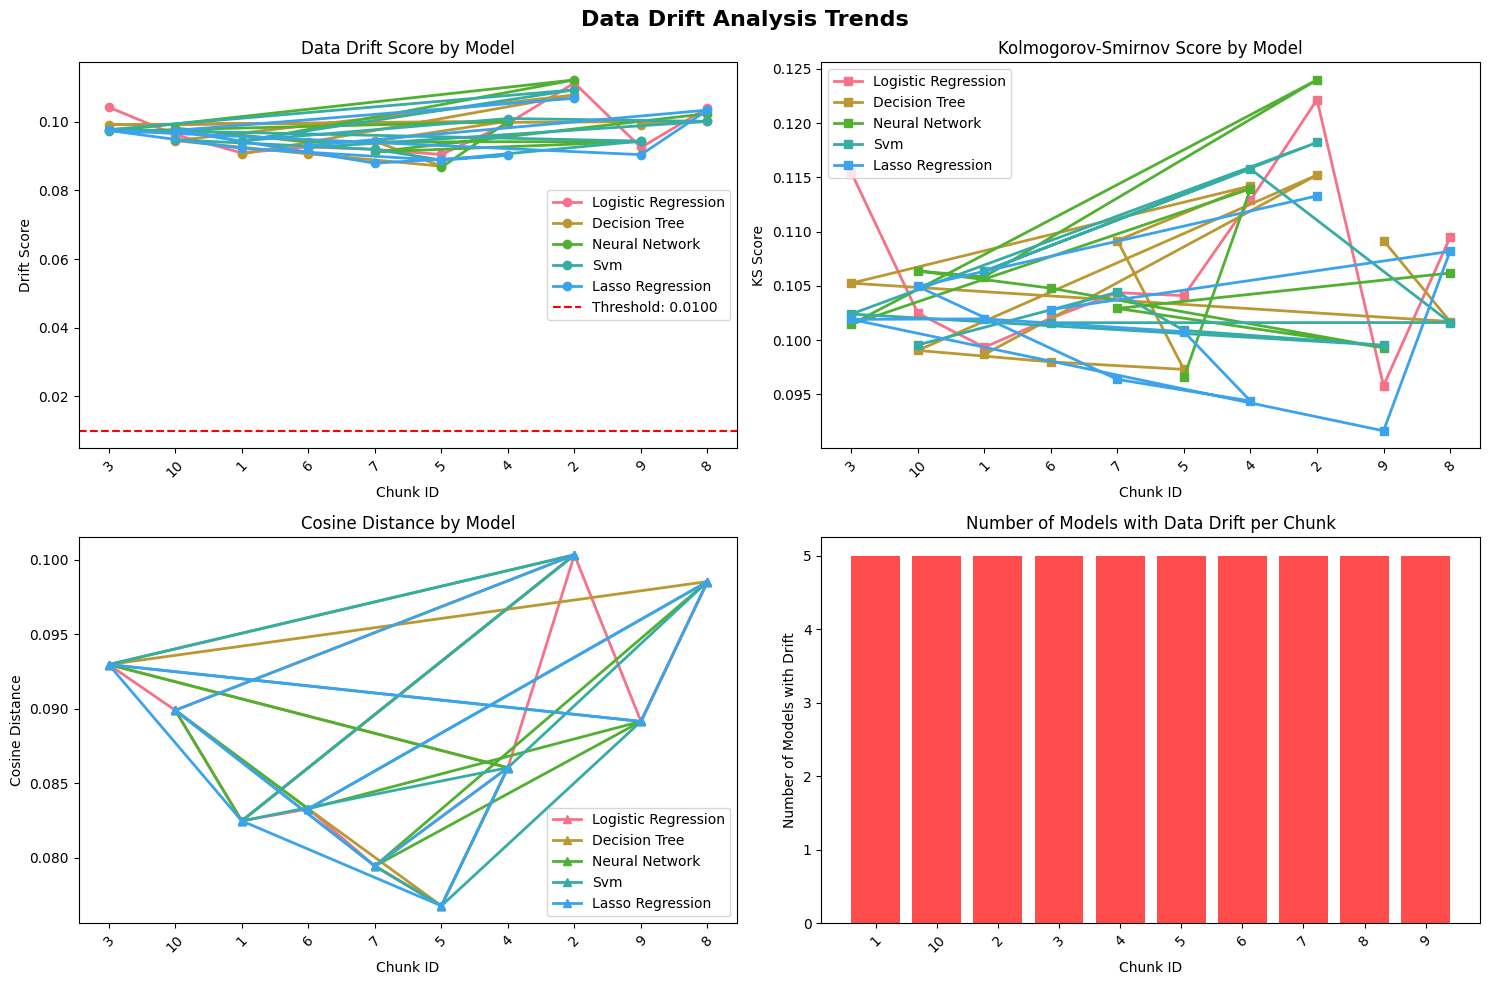


Analysis complete! Check the generated plots for insights.


In [8]:
"""
Drift Visualization Analysis

Author:Prem Kumar Subudhi
Date: 11-Oct-2025
Version: 1.0

Description:
This script provides comprehensive visualization and analysis of data drift and concept drift
results generated by the DataDriftAnalyzer. It creates informative plots and summary tables
to help identify distribution shifts and performance degradation across model chunks.

Processing Steps:
1. CONFIGURATION LOADING: Loads visualization parameters and file paths from YAML configuration
2. DATA INGESTION: Loads pre-computed drift analysis results from pickle files
3. DATA STRUCTURING: Transforms raw drift data into structured DataFrames for analysis
4. SUMMARY GENERATION: Creates comprehensive drift summaries and statistics
5. VISUALIZATION: Generates multi-panel plots showing drift trends across models and chunks
6. TREND ANALYSIS: Identifies patterns in data distribution shifts and model performance changes

Dependencies:
- pandas, matplotlib, seaborn, numpy, pickle
"""

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


def load_config(config_path):
    """Load configuration from YAML file"""
    try:
        import yaml
        with open(config_path, 'r') as file:
            print(f"Loading config from: {config_path}")
            return yaml.safe_load(file)
    except Exception as e:
        print(f"Error loading config: {e}")
        return {
            'paths': {
                'drift_reports_dir': 'drift_reports',
                'drift_file': 'test_data_drift_report.pkl'
            },
            'drift_detection': {
                'data_drift_threshold': 0.01,
                'concept_drift_threshold': 0.006
            }
        }


config = load_config("config.yaml")


def load_drift_data(file_path):
    """Load the drift analysis data from pickle file"""
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        print(f"Successfully loaded drift data from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


def create_data_drift_table(drift_data):
    """Create a DataFrame for data drift results"""
    data_drift = drift_data.get('data_drift', {})
    chunks = []

    for chunk_name, chunk_data in data_drift.items():
        if '_chunk_' in chunk_name and '_to_test' in chunk_name:
            model_name = chunk_name.split('_chunk_')[0]
            chunk_id = chunk_name.split('_chunk_')[1].replace('_to_test', '')

            chunks.append({
                'Model': model_name,
                'Chunk_ID': chunk_id,
                'Data_Drift_Score': chunk_data.get('data_drift_score', 0),
                'KS_Score': chunk_data.get('ks_score', 0),
                'Cosine_Distance': chunk_data.get('cosine_distance', 0),
                'Has_Drift': chunk_data.get('has_drift', False)
            })

    return pd.DataFrame(chunks)


def create_concept_drift_table(drift_data):
    """Create a DataFrame for concept drift results"""
    concept_drift = drift_data.get('concept_drift', {})
    chunks = []

    for chunk_name, chunk_data in concept_drift.items():
        if '_chunk_' in chunk_name and '_to_test' in chunk_name:
            model_name = chunk_name.split('_chunk_')[0]
            chunk_id = chunk_name.split('_chunk_')[1].replace('_to_test', '')

            chunks.append({
                'Model': model_name,
                'Chunk_ID': chunk_id,
                'Concept_Drift_Score': chunk_data.get('concept_drift_score', 0),
                'Accuracy_Drop': chunk_data.get('accuracy_drop', 0),
                'Train_Accuracy': chunk_data.get('train_accuracy', 0),
                'Test_Accuracy': chunk_data.get('test_accuracy', 0),
                'Has_Drift': chunk_data.get('has_drift', False)
            })

    return pd.DataFrame(chunks)


def get_model_summaries(drift_data):
    """Extract model summaries from concept drift data"""
    concept_drift = drift_data.get('concept_drift', {})
    summaries = {}

    for key, value in concept_drift.items():
        if key.endswith('_summary'):
            model_name = key.replace('_summary', '')
            summaries[model_name] = value

    return summaries


def plot_data_drift_trends(df_data_drift, data_drift_threshold=0.01):
    """Plot data drift trends over chunks"""
    if df_data_drift.empty:
        print("No data drift data available for plotting")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, 'No Data Drift Data Available',
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=14)
        ax.set_title('Data Drift Analysis - No Data')
        return fig

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Data Drift Analysis Trends', fontsize=16, fontweight='bold')

    # Data Drift Score by model
    for model in df_data_drift['Model'].unique():
        model_data = df_data_drift[df_data_drift['Model'] == model]
        axes[0, 0].plot(model_data['Chunk_ID'], model_data['Data_Drift_Score'],
                       marker='o', linewidth=2, label=model.replace('_', ' ').title())

    axes[0, 0].axhline(y=data_drift_threshold, color='r', linestyle='--',
                      label=f'Threshold: {data_drift_threshold:.4f}')
    axes[0, 0].set_title('Data Drift Score by Model')
    axes[0, 0].set_ylabel('Drift Score')
    axes[0, 0].set_xlabel('Chunk ID')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)

    # KS Score
    for model in df_data_drift['Model'].unique():
        model_data = df_data_drift[df_data_drift['Model'] == model]
        axes[0, 1].plot(model_data['Chunk_ID'], model_data['KS_Score'],
                       marker='s', linewidth=2, label=model.replace('_', ' ').title())
    axes[0, 1].set_title('Kolmogorov-Smirnov Score by Model')
    axes[0, 1].set_ylabel('KS Score')
    axes[0, 1].set_xlabel('Chunk ID')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Cosine Distance
    for model in df_data_drift['Model'].unique():
        model_data = df_data_drift[df_data_drift['Model'] == model]
        axes[1, 0].plot(model_data['Chunk_ID'], model_data['Cosine_Distance'],
                       marker='^', linewidth=2, label=model.replace('_', ' ').title())
    axes[1, 0].set_title('Cosine Distance by Model')
    axes[1, 0].set_ylabel('Cosine Distance')
    axes[1, 0].set_xlabel('Chunk ID')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Drift Detection
    drift_counts = df_data_drift.groupby('Chunk_ID')['Has_Drift'].sum()
    colors = ['red' if count > 0 else 'green' for count in drift_counts]
    axes[1, 1].bar(drift_counts.index, drift_counts.values, color=colors, alpha=0.7)
    axes[1, 1].set_title('Number of Models with Data Drift per Chunk')
    axes[1, 1].set_ylabel('Number of Models with Drift')
    axes[1, 1].set_xlabel('Chunk ID')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig


def main():
    """Main function to run the drift analysis visualization"""
    # Load the data
    drift_reports_dir = config['paths']['drift_reports_dir']
    drift_file = config['paths']['drift_file']
    file_path = os.path.join(drift_reports_dir, drift_file)

    drift_data = load_drift_data(file_path)

    if drift_data is None:
        print("Failed to load data. Please check the file path.")
        print(f"Looking for: {file_path}")
        return

    # Display summary
    summary = drift_data.get('summary', {})
    print("="*50)
    print("DRIFT ANALYSIS SUMMARY")
    print("="*50)
    print(f"Analysis Timestamp: {summary.get('analysis_timestamp', 'N/A')}")
    print(f"Test Data Size: {summary.get('test_data_size', 'N/A')}")
    print(f"Total Chunks Analyzed: {summary.get('total_chunks_analyzed', 'N/A')}")

    # Create tables
    df_data_drift = create_data_drift_table(drift_data)
    df_concept_drift = create_concept_drift_table(drift_data)
    model_summaries = get_model_summaries(drift_data)

    # Print results
    if not df_data_drift.empty:
        print("\nDATA DRIFT RESULTS:")
        print(df_data_drift.round(6).to_string(index=False))

    if not df_concept_drift.empty:
        print("\nCONCEPT DRIFT RESULTS:")
        print(df_concept_drift.round(6).to_string(index=False))

    # Create visualizations
    print("\nGenerating visualizations...")

    # Data drift trends
    fig1 = plot_data_drift_trends(df_data_drift,
                                 data_drift_threshold=config['drift_detection']['data_drift_threshold'])
    plt.show()

    print("\nAnalysis complete! Check the generated plots for insights.")


if __name__ == "__main__":
    main()